# ISPR - Midterm 3 - Assignment 1 - Sergio Latrofa - 640584
## Hand-wirtten digits denoising using autoencoders

## Assignment 

Train a denoising or a contractive autoencoder on the MNIST dataset: try out different architectures for the autoencoder, including a single layer autoencoder, a deep autoencoder with only layerwise pretraining and a deep autoencoder with fine tuning. It is up to you to decide how many neurons in each layer and how many layers you want in the deep autoencoder. Show an accuracy comparison between the different configurations.

given the encoding z1 of image x1 and z2 of image x2, a latent space interpolation is an encoding that obtained with the linear interpolation z* = a*z1 + (1 - a)*z2, with a in [0, 1]. Perform a latent space interpolation and visualize the results using:
- z1 and z2 from the same class
- z1 and z2 from different classes
Plot the results, for example by showing the image reconstructions for a=0.0, 0.1, 0.2, …, 1.0. Are the resulting images plausible digits?

Try out what happens if you feed one of the autoencoders with a random noise image and then you apply the iterative gradient ascent process described in the lecture to see if the reconstruction converges to the data manifold.


## How the task has been structured

Experimentation has been carried on considering "classical" AE (train and target data identical), and DAE (Denoising Autoencoders). 
The three versions (flatten, deep, and fine tuend) have been built and trained for both the two families. 
MSE has been evaluated and compared for the six models along with a series of plotted example of denoise.
Linear interpolation has also been tried with all the models, producing overall similar results. At the end, gradient ascent has been setted up for the **Fine Tuned Deep DAE, ** confirming the mainfold assumption. Trial with the other AEs have been plotted, but the optimal parameter configuration has not been searched. 

## Notebook Organization

The notebook is divided in sections (to be executed sequentially). 
The order of operation is described in the above section. In the various sections you ou will find: 

1.   Design and Training of the AEs
2.   Empirical evaluation on Test Data
3.   Linear Interpolation plots
4.   Manifold convergence proof
5.   Conclusions and final comments


# Autoencoder Design and Training 

## MINST Import 

Import MNIST dataset, along with library functions for NN implementation and training, data sampling and digits plot. 

In [1]:
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

from random import seed, sample, choice

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from keras import layers, losses
from keras.models import Model, clone_model

seed(123)

In [2]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.8.0


In [3]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


Further split training data into Training Set and Validation Set,the Test Set remains the one provided. 

In [5]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [6]:
print (x_train.shape)
print (x_test.shape)

(60000, 784)
(10000, 784)


In [7]:
x_val = x_train[50000:60000]
y_val = y_train[50000:60000]

x_train = x_train[0:50000]
y_x_train = y_train[0:50000]

In [8]:
FLATTEN_INPUT_DIM = 784

Pick *n* random digits from the test set (Useful for examples plots). 

In [9]:
def random_digits(n = 10, same_digit=False, noise=False): 
  mnist_sample = []
  if noise: 
    mnist_sample = x_test_noise[ np.where(y_test == same_digit ) ] if same_digit else x_test_noise
  else:
    mnist_sample = x_test[ np.where(y_test == same_digit ) ] if same_digit else x_test
  
  return np.array(sample(list(mnist_sample), n))

In [10]:
def all_digits(digit, dset = (x_test, y_test)): 
  xs, ys = dset
  return xs[np.where(ys == digit)]

##Plotting Functions

Visually compare *n* original digits and the their reconstruction. 

In [11]:
def plot_rec(x_test, x_rec, n=10, rec=True):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_rec[i].reshape(28, 28))
    plt.title("reconstructed" if rec else "original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

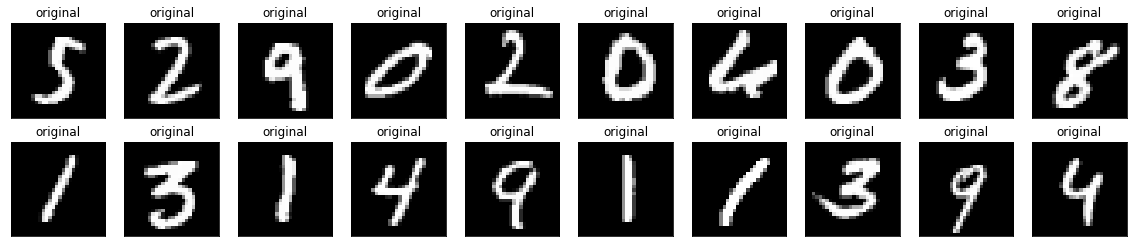

In [12]:
plot_rec(random_digits(), random_digits(), rec=False)

## Create a noised version of the MNIST

Use Gausssian Noise level from Keras to create a "corrupted" version of the dataset, and train or evaluate the denoising power of our AEs.

In [13]:
noiser = layers.GaussianNoise(0.4, 0)
x_train_noise = noiser(x_train, training=True).numpy()
x_val_noise = noiser(x_val, training=True).numpy()
x_test_noise = noiser(x_test,  training=True).numpy()

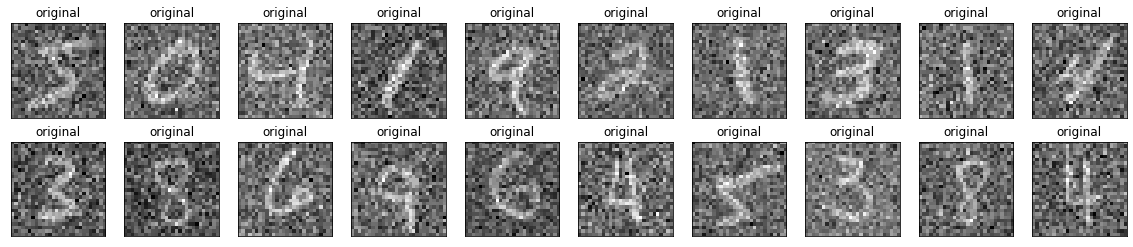

In [14]:
plot_rec(x_train_noise, x_val_noise, rec=False)

## One level AE

Let's begin implementing a linear autoencoder, with one internal layer only. 

In [15]:
LATENT_DIM = 128

In [16]:
def design_AE(latent_dim, input_size):

  class Autoencoder(Model):
    def __init__(self, latent_dim):
      super(Autoencoder, self).__init__()
      self.latent_dim = latent_dim   

      self.encoder = tf.keras.Sequential([
        layers.Dense(latent_dim, activation='relu'),
      ])

      self.decoder = tf.keras.Sequential([
        layers.Dense(input_size, activation='sigmoid')
      ])
      
    def call(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

  return Autoencoder(latent_dim)

In [17]:
AE = design_AE(LATENT_DIM, FLATTEN_INPUT_DIM )

In [18]:
AE.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [19]:
AE.fit(x_train, x_train,
                epochs=5,
                shuffle=True,
                validation_data=(x_val, x_val)
                )

Epoch 1/5
1563/1563 [==============================] - 12s 7ms/step - loss: 0.0197 - val_loss: 0.0067
Epoch 2/5
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0048 - val_loss: 0.0037
Epoch 3/5
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 4/5
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 5/5
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0023 - val_loss: 0.0022


Check dimensionality of the encoding. 

In [101]:
r_digits = random_digits()
r_digits.shape

(10, 784)

Check if the reconstruction works as expected. 

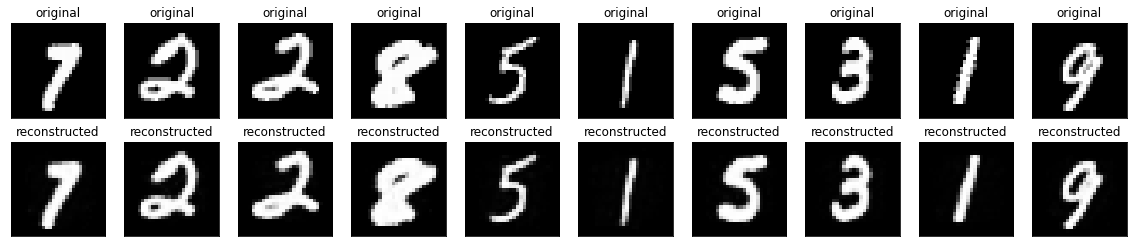

In [102]:
plot_rec(r_digits, AE(r_digits).numpy())


## One level deonsing AE

To make our flatten AE a Denoisng one, jus train it on the "currupted" version of the training data. Target will be their clean version.

In [22]:
denoising_AE = design_AE(LATENT_DIM, FLATTEN_INPUT_DIM )
denoising_AE.compile(optimizer='adam', loss=losses.MeanSquaredError())
denoising_AE.fit(x_train_noise, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_val_noise, x_val)
                )

Epoch 1/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0263 - val_loss: 0.0149
Epoch 2/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0134 - val_loss: 0.0127
Epoch 3/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0121 - val_loss: 0.0122
Epoch 4/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0116 - val_loss: 0.0119
Epoch 5/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0113 - val_loss: 0.0117
Epoch 6/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0111 - val_loss: 0.0116
Epoch 7/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0110 - val_loss: 0.0115
Epoch 8/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0109 - val_loss: 0.0114
Epoch 9/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0108 - val_loss: 0.0115
Epoch 10/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.010

Check the digit reconstruction:

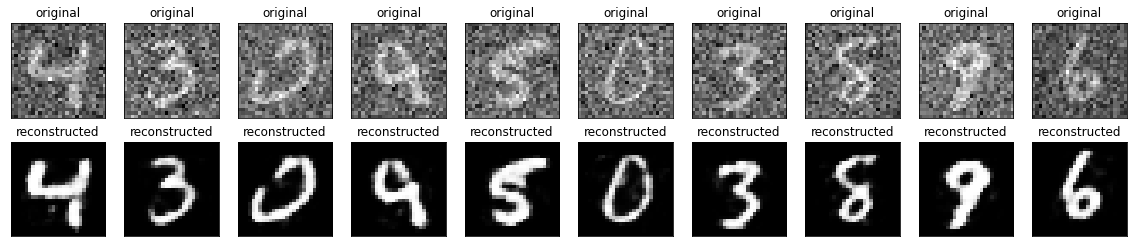

In [23]:
r_digits = random_digits(noise=True)
plot_rec(r_digits, denoising_AE(r_digits).numpy())

## Deep AE - Layerwise pre-training

Define here the number of units for each layer (correpsponding to the encoding dimensionality). 

Trials have demonstrated that adding more than two hidden layers does not produce good result for the MNIST task. Further trials should consider intrudction of regularization, a higher numper of epoch (and so more available traing time) and in general msystematic model selections for each layer. 

In [99]:
LATENT_DIMS = [ 512, 128 ]

Set a fixed (low) number of epochs, equal for each layer, depending on the time you want to spend waiting the training pahse to end. 

In [25]:
EPOCHS_NUM = 5

Train each laywer as an independe auotoencoder, fed with the data encoded at the previous level. An array of AEs will be produced. 

In [26]:
def layerwise_train(x_train,  latent_dims, initial_shape, x_val): 
  levels = []
  last_enc = x_train

  for i in range(len(latent_dims)): 
    input_size = initial_shape if i == 0 else latent_dims[i-1]
    autoencoder =  design_AE(latent_dims[i], input_size)
   
    #Train autoencoder on last encoding. 
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

    autoencoder.fit(last_enc, last_enc, #not sure if last dec or last enc
                      epochs=EPOCHS_NUM,
                      shuffle=True
                      )
                      
    last_enc = autoencoder.encoder(last_enc).numpy()
    levels.append(autoencoder)
    
  return levels

In [27]:
LEVELS = layerwise_train(x_train, LATENT_DIMS, FLATTEN_INPUT_DIM, x_val)

Epoch 1/5
1563/1563 [==============================] - 15s 10ms/step - loss: 0.0111
Epoch 2/5
1563/1563 [==============================] - 16s 10ms/step - loss: 0.0022
Epoch 3/5
1563/1563 [==============================] - 15s 10ms/step - loss: 0.0016
Epoch 4/5
1563/1563 [==============================] - 15s 10ms/step - loss: 0.0013
Epoch 5/5
1563/1563 [==============================] - 15s 9ms/step - loss: 0.0012
Epoch 1/5
1563/1563 [==============================] - 5s 3ms/step - loss: 0.6120
Epoch 2/5
1563/1563 [==============================] - 5s 3ms/step - loss: 0.5710
Epoch 3/5
1563/1563 [==============================] - 5s 3ms/step - loss: 0.5652
Epoch 4/5
1563/1563 [==============================] - 5s 3ms/step - loss: 0.5639
Epoch 5/5
1563/1563 [==============================] - 4s 3ms/step - loss: 0.5634


Stack the different AEs one on top of each other, actually obtaining a single **deep** model.

In [28]:
def design_deep_AE(levels, latent_dims, input_size): 
    class DeepAutoencoder(Model):
      def __init__(self, levels, latent_dims, input_size ):
        super(DeepAutoencoder, self).__init__()
        self.latent_dims = latent_dims   

        self.encoder = tf.keras.Sequential()
        self.encoder.add(tf.keras.Input(shape=(input_size,)))
        for i in range(len(levels)): 
          enc_layer = layers.Dense(latent_dims[i], activation='relu')
          self.encoder.add(enc_layer)

        self.decoder = tf.keras.Sequential()
        self.decoder.add(tf.keras.Input(shape=(latent_dims[len(latent_dims)-1],)))
        for i in reversed(range(len(latent_dims)-1)): 
          dec_layer = layers.Dense(latent_dims[i], activation='sigmoid')
          self.decoder.add(dec_layer)

        self.decoder.add(layers.Dense(input_size, activation='sigmoid'))

      def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    dae = DeepAutoencoder(levels, latent_dims, input_size)
    dae.compile(optimizer='adam', loss=losses.MeanSquaredError())

    #Transfer weights from previous pretained layers
    for i in range(len(levels)):
      dae.encoder.get_layer(index=i).set_weights(levels[i].encoder.get_weights())
      dae.decoder.get_layer(index=i).set_weights(levels[len(levels) -1 - i].decoder.get_weights())

    return dae

In [29]:
deep_AE = design_deep_AE(LEVELS, LATENT_DIMS, FLATTEN_INPUT_DIM)

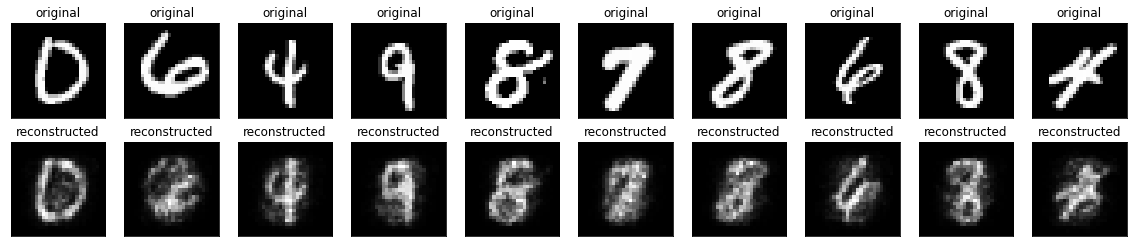

In [30]:
r_digits = random_digits()
plot_rec(r_digits, deep_AE(r_digits).numpy())

## Deep Denoisng AE - Layerwise pre-training

To layerwise pretrain the DAE, Gaussian noise (at a certain std) will be added to each new input encoding and so one. 

Input training data have been provided in their noised version too, as an experimentation choiche. 

In [31]:
def layerwise_train_noise(x_noise, x_clean,  latent_dims, initial_shape, noise_std = 0.2):
  levels = []

  noisy_enc = x_noise
  clean_enc = x_clean

  noiser = layers.GaussianNoise(noise_std, 0)

  for i in range(len(latent_dims)): 
    input_size = initial_shape if i == 0 else latent_dims[i-1]
    autoencoder =  design_AE(latent_dims[i], input_size)
   
    #Train autoencoder on last encoding. 
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

    autoencoder.fit(noisy_enc, clean_enc,
                      epochs=EPOCHS_NUM,
                      shuffle=True
                      )
    # We wish to learn the clean encoding. 
    clean_enc = autoencoder.encoder(clean_enc).numpy()
    # From "corrupted" training examples
    noisy_enc = noiser(clean_enc, training=True)

    levels.append(autoencoder)
  return levels

In [32]:
DENOISING_LEVELS = layerwise_train_noise(x_train_noise, x_train, LATENT_DIMS, FLATTEN_INPUT_DIM, 0.2)

Epoch 1/5
1563/1563 [==============================] - 15s 10ms/step - loss: 0.0189
Epoch 2/5
1563/1563 [==============================] - 15s 9ms/step - loss: 0.0110
Epoch 3/5
1563/1563 [==============================] - 15s 9ms/step - loss: 0.0100
Epoch 4/5
1563/1563 [==============================] - 15s 9ms/step - loss: 0.0094
Epoch 5/5
1563/1563 [==============================] - 15s 9ms/step - loss: 0.0090
Epoch 1/5
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3658
Epoch 2/5
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3309
Epoch 3/5
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3271
Epoch 4/5
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3255
Epoch 5/5
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3247


In [33]:
deep_denosing_AE = design_deep_AE(DENOISING_LEVELS, LATENT_DIMS, FLATTEN_INPUT_DIM)

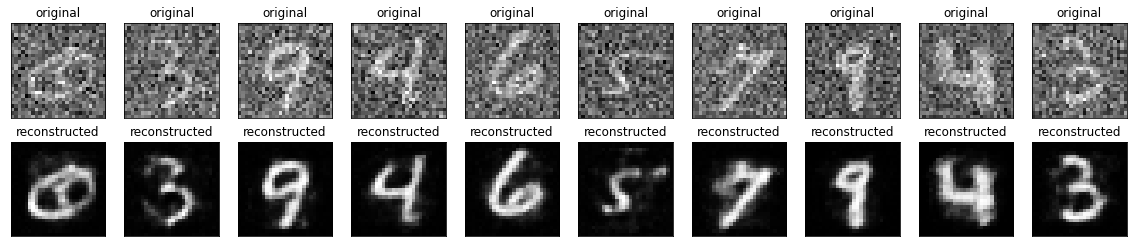

In [34]:
r_digits = random_digits(noise=True)
plot_rec(r_digits, deep_denosing_AE(r_digits).numpy())

## Fine Tuned Deep AE 

WI will create a copy of the previously layerwise trained AE and retrain it with our data (fine tuning). 

In [35]:
ft_AE = design_deep_AE(LEVELS, LATENT_DIMS, FLATTEN_INPUT_DIM)

In [36]:
ft_AE.fit(x_train, x_train,epochs=10,shuffle=True, validation_data=(x_val, x_val))

Epoch 1/10
1563/1563 [==============================] - 23s 15ms/step - loss: 0.0067 - val_loss: 0.0051
Epoch 2/10
1563/1563 [==============================] - 21s 14ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 3/10
1563/1563 [==============================] - 22s 14ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 4/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 5/10
1563/1563 [==============================] - 27s 17ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 6/10
1563/1563 [==============================] - 21s 13ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 7/10
1563/1563 [==============================] - 21s 14ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 8/10
1563/1563 [==============================] - 21s 13ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 9/10
1563/1563 [==============================] - 21s 13ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 10/10
1563/1563 [==============================] - 20s 13m

Check if the reconstruction works correctly.

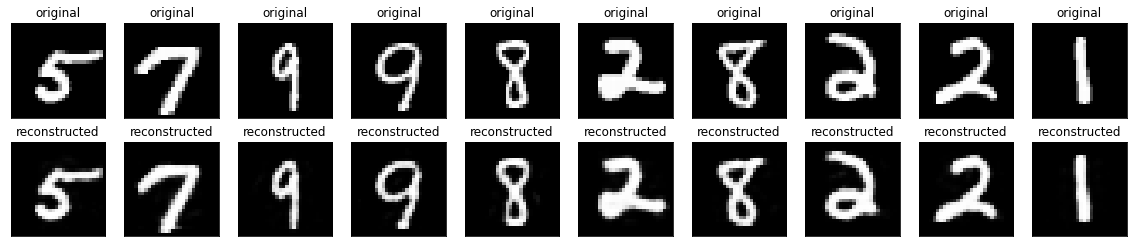

In [37]:
r_digits = random_digits()
plot_rec(r_digits, ft_AE(r_digits).numpy())

## Fine Tuned Deep Denoising AE

Repat the fine tuining for the denoinsing version of the deep auto encoder, this time we will use the corrupted x as input. 

In [38]:
denoising_ft_AE = design_deep_AE(DENOISING_LEVELS, LATENT_DIMS, FLATTEN_INPUT_DIM)

In [39]:
denoising_ft_AE.fit(x_train_noise, x_train, epochs=10, shuffle=True, validation_data=(x_val_noise, x_val))

Epoch 1/10
1563/1563 [==============================] - 25s 16ms/step - loss: 0.0120 - val_loss: 0.0124
Epoch 2/10
1563/1563 [==============================] - 23s 15ms/step - loss: 0.0105 - val_loss: 0.0120
Epoch 3/10
1563/1563 [==============================] - 21s 13ms/step - loss: 0.0099 - val_loss: 0.0121
Epoch 4/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.0094 - val_loss: 0.0120
Epoch 5/10
1563/1563 [==============================] - 23s 14ms/step - loss: 0.0091 - val_loss: 0.0121
Epoch 6/10
1563/1563 [==============================] - 23s 14ms/step - loss: 0.0088 - val_loss: 0.0121
Epoch 7/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.0086 - val_loss: 0.0122
Epoch 8/10
1563/1563 [==============================] - 21s 13ms/step - loss: 0.0084 - val_loss: 0.0122
Epoch 9/10
1563/1563 [==============================] - 21s 13ms/step - loss: 0.0082 - val_loss: 0.0122
Epoch 10/10
1563/1563 [==============================] - 22s 14m

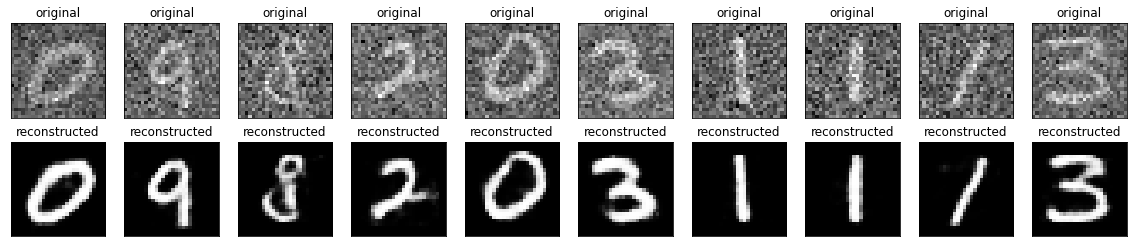

In [40]:
r_digits = random_digits(noise=True)
plot_rec(r_digits, denoising_ft_AE(r_digits).numpy())

# Test Set Evaluation

Import the MSE 

In [41]:
from sklearn.metrics import mean_squared_log_error as MSE

Divide the models for comparison

In [42]:
AE_names = ["Linear", "Deep", "Fine Tuned"]
AEs = [AE, deep_AE, ft_AE]
DAEs = [denoising_AE, deep_denosing_AE , denoising_ft_AE]

Evaluate each model in one shot

In [43]:
def evaluate(x_test, y_test, aes, metric): 
  return list(map(lambda ae: metric(y_test, ae(x_test)), aes ))

### MSE on the test set

Best results on non-corrupted data are obtained with the "flatten" AE.Adding layers is not useful if not dealing with noised data. Best latent representation turns out to be the linear one. 

In [44]:
print(AE_names)
evaluate(x_test, x_test, AEs, MSE)

['Linear', 'Deep', 'Fine Tuned']


[0.0010763803, 0.018259952, 0.001745047]

Results are aligned to the ones of "classical" AE.

In [45]:
print("DENOISING VERSIONS")
print(AE_names)
evaluate(x_test, x_test, DAEs, MSE)

DENOISING VERSIONS
['Linear', 'Deep', 'Fine Tuned']


[0.0021298933, 0.0062985783, 0.0038179911]

### MSE on the noised test set

When dealing with noise the situation does not change for "classic" autoencoders. The flatten one is still the best in terms of loss.  

In [46]:
print(AE_names)
evaluate(x_test_noise, x_test, AEs, MSE)

['Linear', 'Deep', 'Fine Tuned']


[0.009473587, 0.022779886, 0.0126100015]

Difference in terms of performance is quite similar for the tree models, with the flatten one and the fine tuned ones still remaining the best choiches. 

In [47]:
print("DENOISING VERSIONS")
print(AE_names)
evaluate(x_test_noise, x_test, DAEs, MSE)

DENOISING VERSIONS
['Linear', 'Deep', 'Fine Tuned']


[0.0054684025, 0.008895154, 0.005915457]

## Visually comparing AEs for denoising 

In [48]:
noisey = random_digits(10, noise=True)

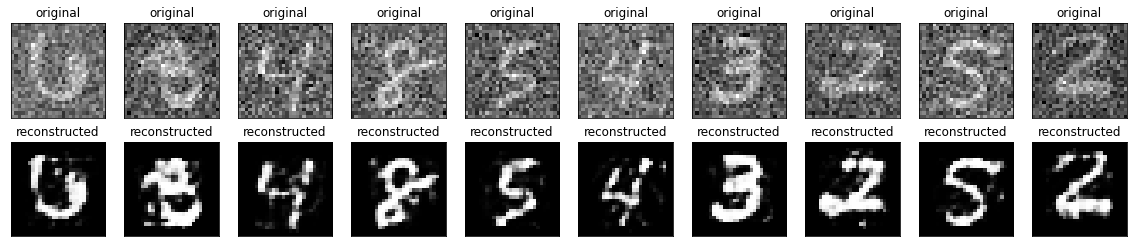

In [49]:
plot_rec(noisey, AE(noisey).numpy(), n=len(noisey)  )

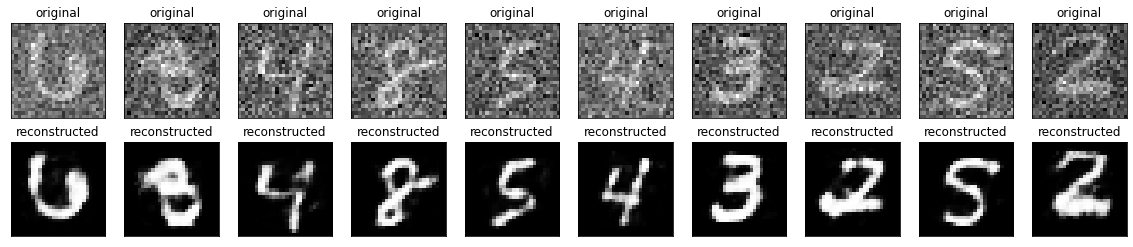

In [50]:
plot_rec(noisey, denoising_AE(noisey).numpy(), n=len(noisey)  )

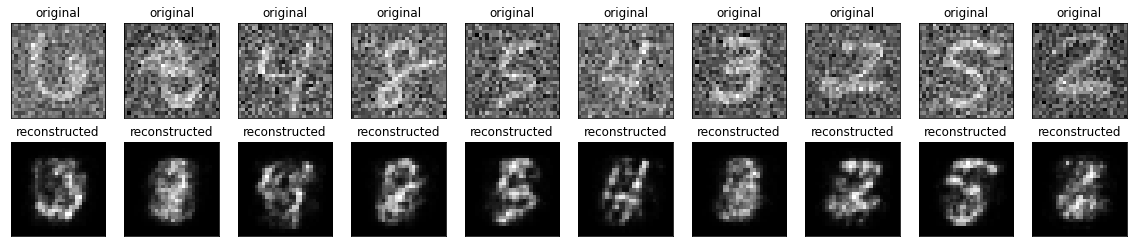

In [51]:
plot_rec(noisey, deep_AE(noisey).numpy(), n=len(noisey)  )

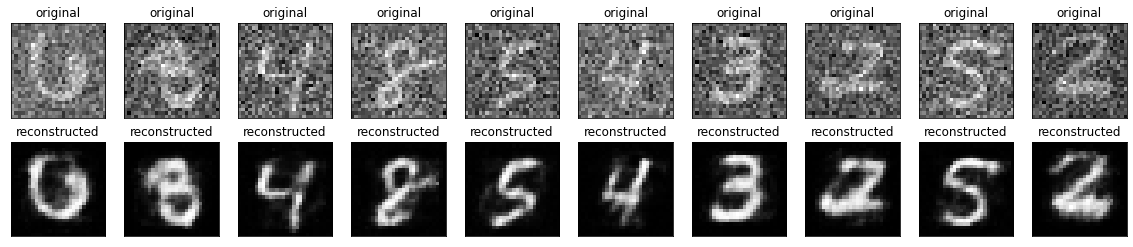

In [52]:
plot_rec(noisey, deep_denosing_AE(noisey).numpy(), n=len(noisey)  )

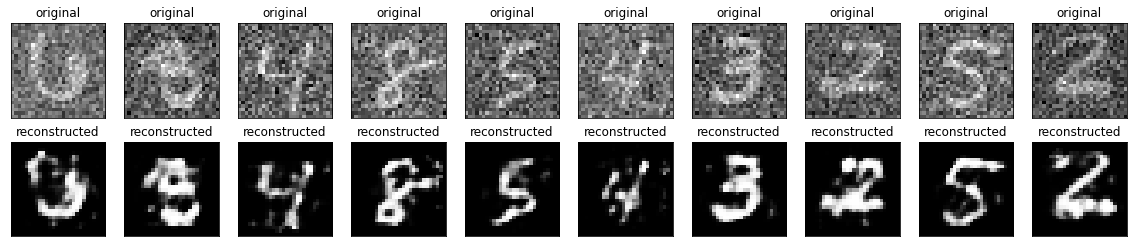

In [53]:
plot_rec(noisey, ft_AE(noisey).numpy(), n=len(noisey)  )

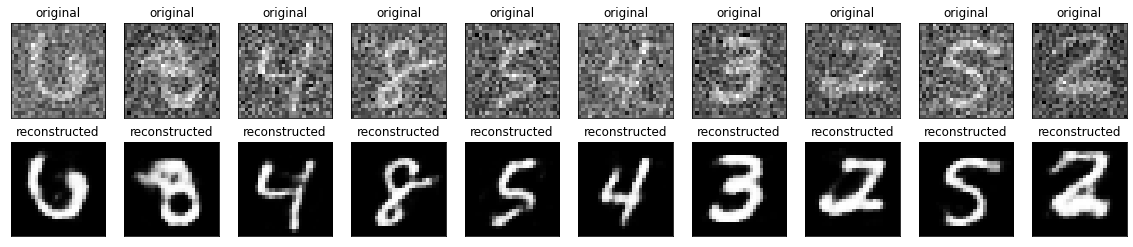

In [54]:
plot_rec(noisey, denoising_ft_AE(noisey).numpy(), n=len(noisey)  )

# Linear Interpolation


### Utility functions

Compare the two original digits with their possible interpolation, at the varying of *a*.

In [55]:
def plot_interp(original, interpolated, step_idx=True):
  plt.figure(figsize=(20,4))
  for i in range(len(original)): 
    ax = plt.subplot(2, len(original), i + 1)
    plt.imshow(original[i].reshape(28, 28))
    plt.title(f"x{i+1}")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

  n = len(interpolated)
  for i in range(len(interpolated)): 
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(interpolated[i].reshape(28, 28))
    plt.title(f"a = {i/n}" if step_idx else i+1)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Linear Interpolation according to the provided formula. 

In [56]:
def linear_interpolation(z1, z2, a): 
  return a*z1 + (1 - a)*z2

Wrapping encoding and decoding, tackling (low level) dimensionality issues with Keras models processing one "row" at a time.

In [57]:
def encode(digit, ae): 
  return ae.encoder(np.expand_dims(digit, axis=0)).numpy()[0]

In [58]:
def decode(encoding, ae):
  return ae.decoder(np.expand_dims(encoding, axis=0)).numpy()[0]

Actual interpolation using autoencoders. 

In [59]:
def interpolate_digits(x1, x2, a, ae): 
  return decode(linear_interpolation( encode(x1, ae ),encode(x2, ae ), a ), ae)

Plotting function for one single interpolation case.

In [60]:
def show_digit_interpolation(x1, x2, a, ae):
  plt.imshow(interpolate_digits(x1, x2, a, ae).reshape((28,28)))

Parameter to define the chaingi rate of *a*.

10 -> a0 = 0.1; a1 = 0.2; ... a9 = 1;





In [61]:
A_STRIDE = 10

Produce n interolated images according to the A_STRIDE parameter. 

In [62]:
def incremental_interpolation(digits, ae):
  x1 = digits[1]
  x2 = digits[0]
  new_digits = []
  for i in range(A_STRIDE):
    new_digits.append(interpolate_digits(x1, x2, i/A_STRIDE, ae))
  return ([x2, x1 ], new_digits)

## Interpolation plots - Same Digits


In [63]:
# No generalized random same digit function here... :(
same_digits = [x_test[4], x_test[6]]

### Flat AE

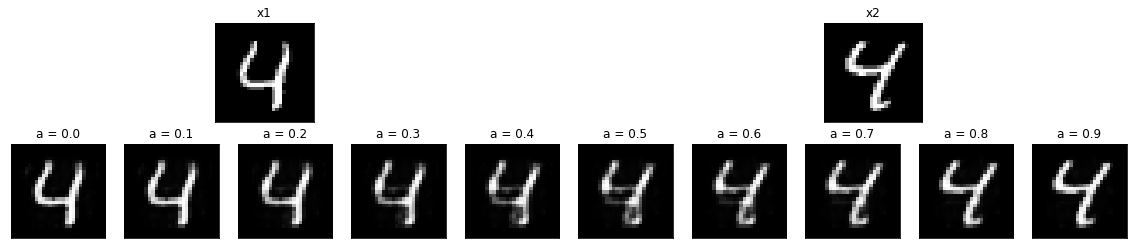

In [64]:
original, interp = incremental_interpolation(same_digits, AE)
plot_interp(original, interp)

### Denoising AE - Same Class Images

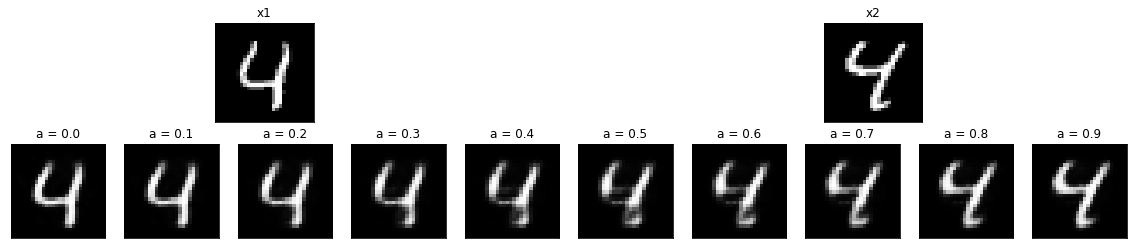

In [65]:
original, interp = incremental_interpolation(same_digits, denoising_AE)
plot_interp(original, interp)

### Deep AE - Same Class Images

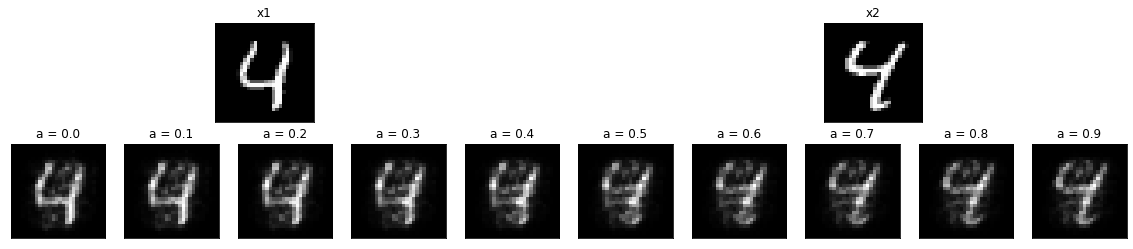

In [66]:
original, interp = incremental_interpolation(same_digits, deep_AE)
plot_interp(original, interp)

### Deep Denoising AE - Same Class Images

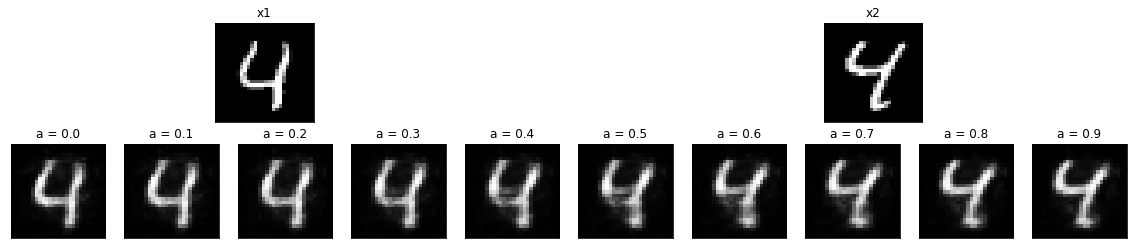

In [67]:
original, interp = incremental_interpolation(same_digits, deep_denosing_AE)
plot_interp(original, interp)

### Fine Tuned AE - Same Class Images 



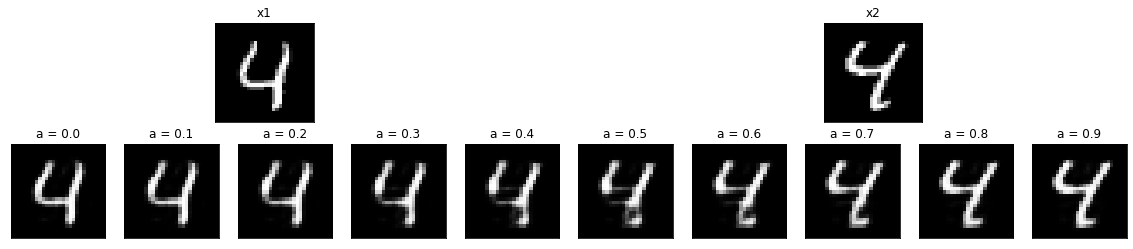

In [68]:
original, interp = incremental_interpolation(same_digits, ft_AE)
plot_interp(original, interp)

### Fine Tuned Denosing AE - Same Class Images 

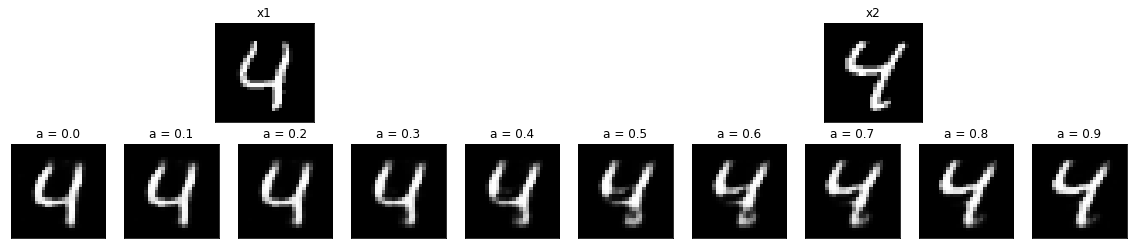

In [69]:
original, interp = incremental_interpolation(same_digits, denoising_ft_AE)
plot_interp(original, interp)

## Interpolation plots - Different Digits

In [70]:
# No generalized random different digits function here... :(
different_digits = [x_test[5], x_test[6]]

### Flat AE - Different Class Images

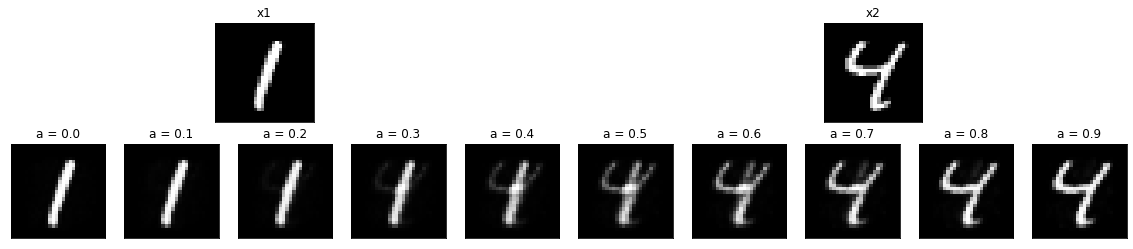

In [71]:
original, interp = incremental_interpolation(different_digits, AE)
plot_interp(original, interp)

### Deep AE - Different Class Images

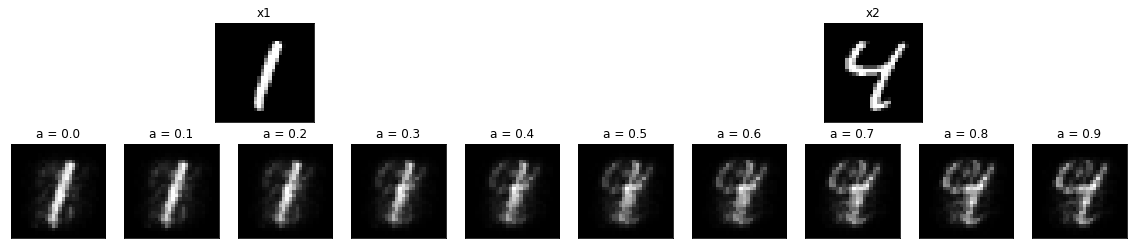

In [72]:
original, interp = incremental_interpolation(different_digits, deep_AE)
plot_interp(original, interp)

### Denoising AE - Same Class Images

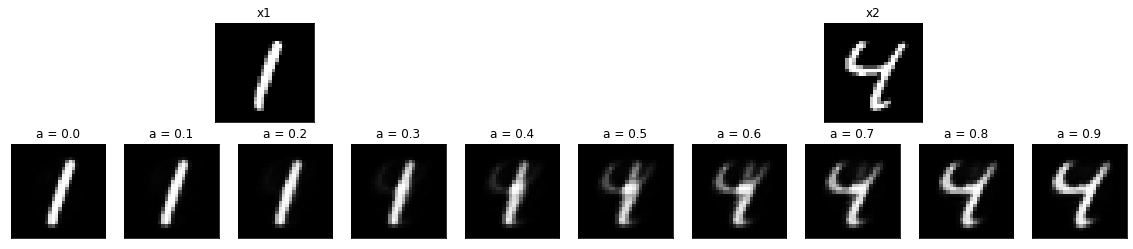

In [73]:
original, interp = incremental_interpolation(different_digits, denoising_AE)
plot_interp(original, interp)

### Deep Denoising AE - Different Class Images

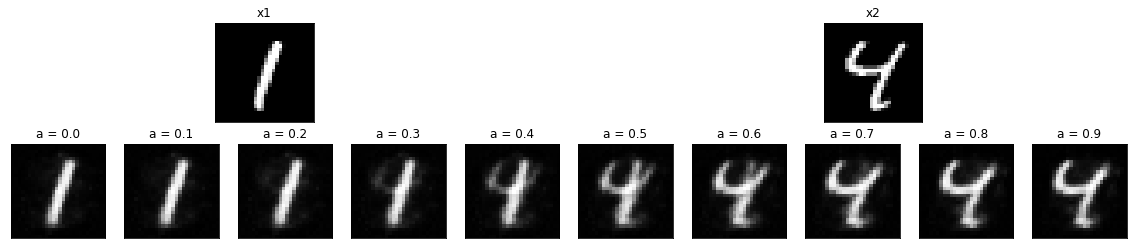

In [74]:
original, interp = incremental_interpolation(different_digits,deep_denosing_AE)
plot_interp(original, interp)

### Fine Tuned AE - Different Class Images
 


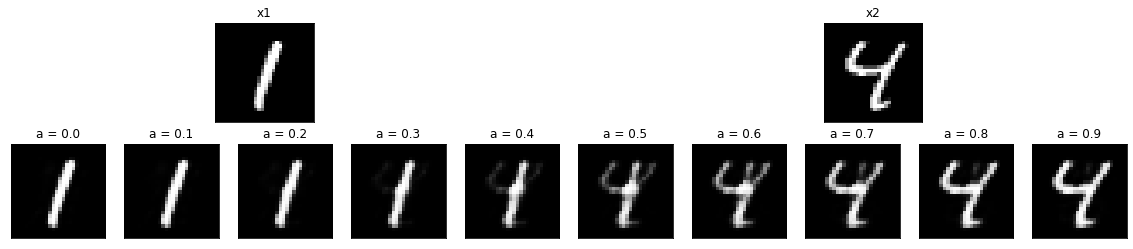

In [75]:
original, interp = incremental_interpolation(different_digits, ft_AE)
plot_interp(original, interp)

### Fine Tuned AE - Different Class Images 

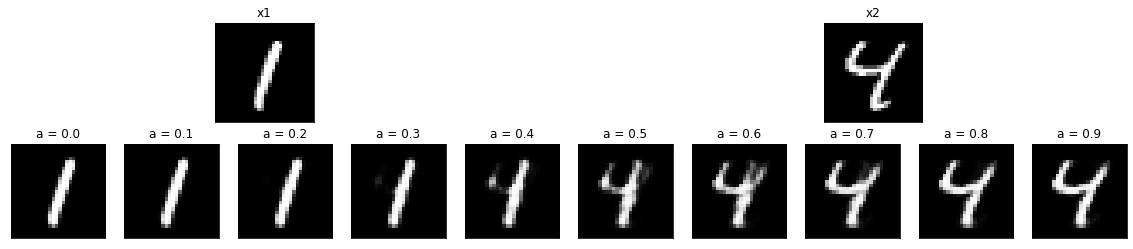

In [76]:
original, interp = incremental_interpolation(different_digits, denoising_ft_AE)
plot_interp(original, interp)

# Gradient Ascent and Convergence to Manifold

## Implementation 

First, calcolate the mean over all images of a certain digit: the one that we want to "visit" the manifold of. 

In [77]:
def digit_mean(d=0):
  all_d_digit = x_test[np.where(y_test == d)]
  mean = np.mean(all_d_digit, axis=0)
  plt.imshow(mean.reshape(28, 28))
  plt.show()
  return mean

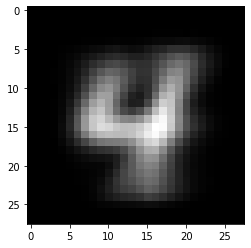

In [78]:
mean = digit_mean(4)

Generate a random "pure noise" image

In [79]:
np.random.rand(2,784)

array([[0.73566284, 0.33125256, 0.42519661, ..., 0.14212437, 0.95450721,
        0.22965539],
       [0.23163609, 0.29318251, 0.30467638, ..., 0.95375627, 0.06495436,
        0.48058828]])

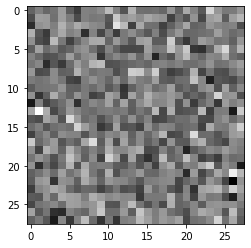

In [80]:
pure_noise = layers.GaussianNoise(1, 0)(np.random.rand(1,784),  training=True).numpy()
plt.imshow(pure_noise.reshape(28, 28))
plt.show()

We will use the loss function to gradually correct our noise image, being it proportional to the gradient of the probability distribution of the digit. 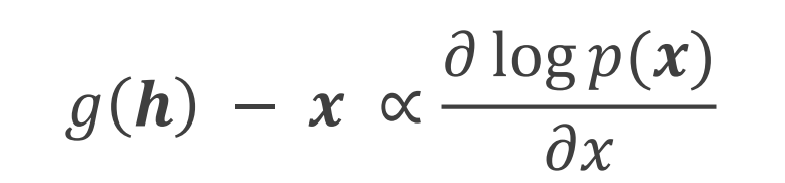

In [81]:
def calc_loss(input, target, model):
  return (model(input) - target)

During the gradient ascent iterative process, we add the gradient the noisy image in order to move it in the direction of the mean. 

In [82]:
def ascention(input, target, model, n=10, eta=1, normalization=False, inversion=False): 
  target = model(np.expand_dims(target, 0))
  imgs = []
  for i in range(n): 
    #Use loss as gradient, exploitng proportionaliity
    gradient = calc_loss(input, target, model)

    input = input + gradient*eta
    # Normalize at each step to avoid float explosion
    if normalization:
      input /= np.linalg.norm(input)
    
    imgs.append(-(input.numpy()) if inversion else input.numpy())
  return imgs

Let's test the gradient ascent iterative process...

## Search of parameters (Deep Fine Tuned DAE)

In this first setting, we need to increase the loss in order to make the changing visible. 

In [83]:
mnfd = ascention( input=np.expand_dims(pure_noise[0], 0), target=mean,  model=denoising_ft_AE, n=10, eta=2.4)

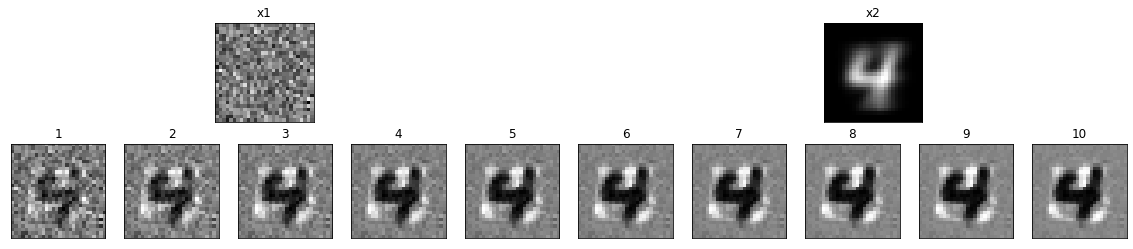

In [84]:
plot_interp([pure_noise, mean ], mnfd , step_idx=False)

To visaully improve the results we normalized the image at each step. Obtaining a more clear result 

In [85]:
mnfd = ascention( input=np.expand_dims(pure_noise[0], 0),target=mean,  model=denoising_ft_AE, n=10, eta=0.5, normalization=True)

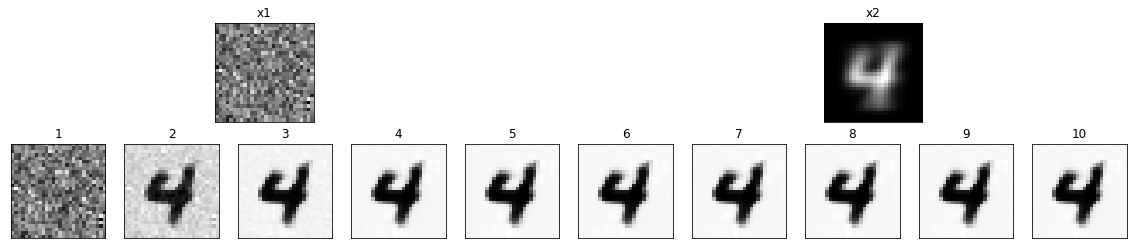

In [86]:
plot_interp([pure_noise, mean ], mnfd , step_idx=False)

Finally, inverting the grayscale colors we can obtain a "MNIST style" result.

In [87]:
mnfd = ascention( input=np.expand_dims(pure_noise[0], 0),target=mean,  model=denoising_ft_AE, n=10, eta=0.1, normalization=True, inversion=True)

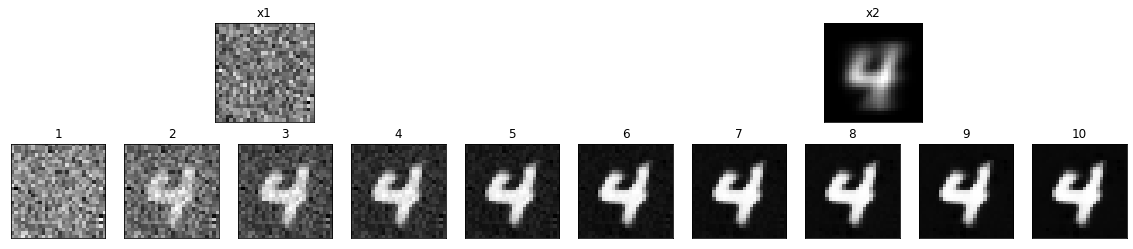

In [88]:
plot_interp([pure_noise, mean ], mnfd , step_idx=False)

## Convergence of the other models

**We expet the same behaviours from all the AEs, with just a small "search" work for the correct "eta" and numer of iterations.**

In [89]:
mnfd = ascention( input=np.expand_dims(pure_noise[0], 0),target=mean,  model=ft_AE, n=10, eta=0.1, normalization=True, inversion=True)

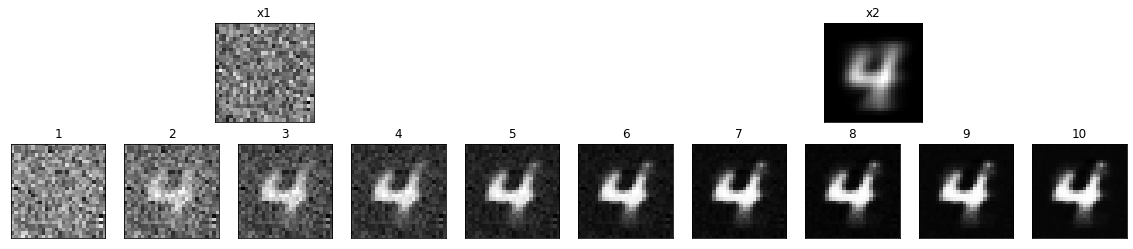

In [90]:
plot_interp([pure_noise, mean ], mnfd , step_idx=False)

In [91]:
mnfd = ascention( input=np.expand_dims(pure_noise[0], 0),target=mean,  model=deep_denosing_AE, n=10, eta=0.1, normalization=True, inversion=True)

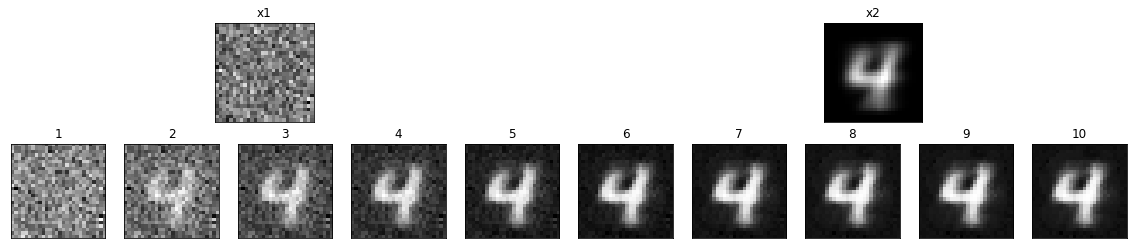

In [92]:
plot_interp([pure_noise, mean ], mnfd , step_idx=False)

In [93]:
mnfd = ascention( input=np.expand_dims(pure_noise[0], 0),target=mean,  model=deep_AE, n=10, eta=0.1, normalization=True, inversion=True)

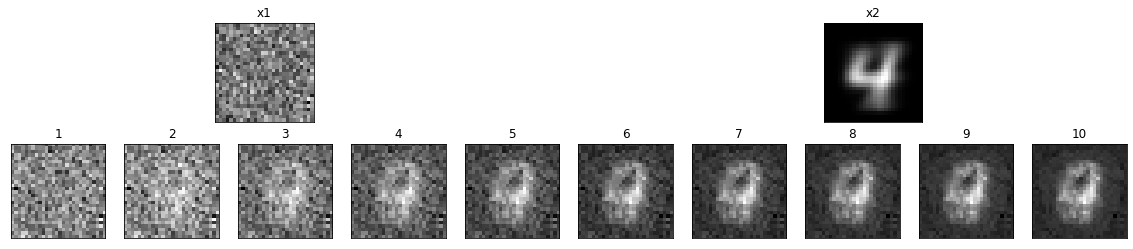

In [94]:
plot_interp([pure_noise, mean ], mnfd , step_idx=False)

In [95]:
mnfd = ascention( input=np.expand_dims(pure_noise[0], 0),target=mean,  model=denoising_AE, n=10, eta=0.1, normalization=True, inversion=True)

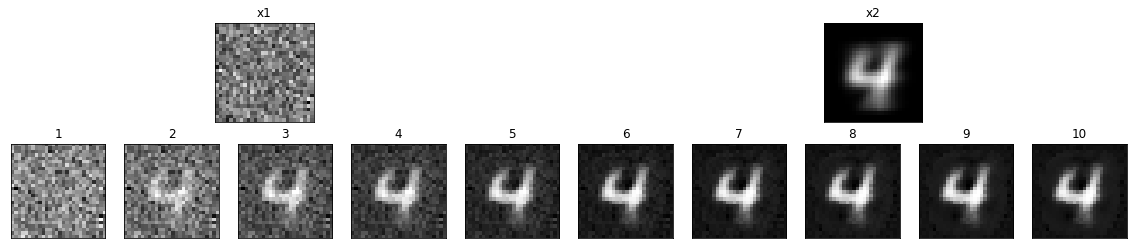

In [96]:
plot_interp([pure_noise, mean ], mnfd , step_idx=False)

In [97]:
mnfd = ascention( input=np.expand_dims(pure_noise[0], 0),target=mean,  model=AE, n=10, eta=0.1, normalization=True, inversion=True)

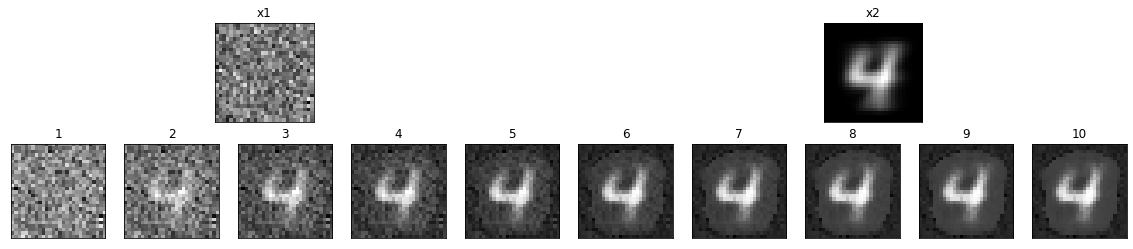

In [98]:
plot_interp([pure_noise, mean ], mnfd , step_idx=False)

**And so it is...**

# Conclusions

## Results

Six different type of AEs have been trained and test. 
Best results in terms of error between original digit and denoised representation were obtained by the one level **DAE** and by the **Deep Fine Tuned DAE**.  Given the slisgtly lower MSE and the considerable difference in training type the best AE for the MNIST task is the "flatten" one. 

Comparing DAE and AE cosniderably highlights the importance of the addition of noise during the training phase, particularly in the "deep architectures" cases. 

The convergence to the manifold of a digit has been proven. In particular the plotted reuslts of the gradient ascent process show how the AE can be used to approximate a distribution, revealing in some way interesting potential for **generative tasks**. 

Interploation plots also allow to understand diffrences between gradient ascent and trivial "image copy" processes. 


## References



*   **Deep Learning book - Ch. 14** - 
https://www.deeplearningbook.org/contents/autoencoders.html

*   **Learning Dynamics of Linear Denoising Autoencoders - Arnu Pretorius, Steve Kroon, Herman Kamper** - 
https://arxiv.org/abs/1806.05413#:~:text=Denoising%20autoencoders%20(DAEs)%20have%20proven,noise%20influences%20learning%20in%20DAEs.
*  **Deep Dreaming Tensowrflow tutorial** (Gradient Ascent in TF) - 
https://www.tensorflow.org/tutorials/generative/deepdream


## Comments and Feedback

The assignment as a whole has been very useful to better understand differences between specifc AE types, and clarify their internal behaviour. 

Mathematical bounds with matrices low rank approximation are more clear now, as far as the meaning of the manifold assumption, now understood as an optimization problem, thanks to the SGD-like approach implemented. 

In particular lot of links with the NN weights optimization emerged (it's quite trivial, cosindering AE are basically NN), ending up with a larger overall personal vision. 

A lot of practice with TF has also been done to accomplsih all the tasks, also solving "low level" issues with tensor shapes, acquiring AI debugging skills.

With respscet to the previous midterms this one was harder, both in terms of theoretical compexity that in programming effort, at least more than personally expectd, even though the icnrease of the complexity was announced.

I hope my feedback to be useful. 